# 01 – Preprocesamiento y Normalización de Landmarks

Este notebook prepara el conjunto de datos para entrenamiento del modelo de reconocimiento de actividad humana (HAR).

**Pasos principales:**
1. Cargar datos desde Supabase o CSV.
2. Explotar los frames y filtrar por calidad.
3. Normalizar coordenadas de landmarks.
4. Suavizar ruido temporal.
5. Agregar características (ángulos, velocidades, inclinación del tronco) por ventana.
6. Exportar `features.csv` para los notebooks de modelado.

## Dependencias y entorno

In [2]:
%pip install -r ../requirements.txt

import os
import pandas as pd
from dotenv import load_dotenv
import sys, os
sys.path.append(os.path.abspath(os.path.join("..", "..")))

from Entrega2.src.utils.data_utils import load_from_supabase, explode_frames_table
from Entrega2.src.features.feature_engineering import prepare_video_windows

load_dotenv()

# Variables clave
OUTPUT_DIR = os.getenv("OUTPUT_DIR", "../experiments/results")
OUTPUT_CSV = os.getenv("OUTPUT_CSV", "features.csv")

os.makedirs(OUTPUT_DIR, exist_ok=True)


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'a:\Deployments\IA1_VideoActivityRecognition_ICESI_2025_2\venv\Scripts\python.exe -m pip install --upgrade pip' command.


## Cargar datos desde supabase

In [3]:
print("🔌 Cargando datos desde Supabase...")
df = load_from_supabase()

print("✅ Registros cargados:")
print(df.head(3))
print(f"Total videos: {len(df)}")

🔌 Cargando datos desde Supabase...
✅ Registros cargados:
   id_lm                              video_id  \
0     41  8e26196e-4e06-40fe-9ca2-809f0858685c   
1     42  1d00f9dc-1af5-49d0-9210-f56186842ec9   
2     43  5276d09c-8ec6-4aec-83b4-078748e0e64a   

                                           landmarks  \
0  {'fps': 30.0, 'frames': [{'landmarks': {'head'...   
1  {'fps': 30.0, 'frames': [{'landmarks': {'head'...   
2  {'fps': 30.00968054211036, 'frames': [{'landma...   

                   created_at  \
0  2025-10-12T00:26:32.197995   
1  2025-10-12T00:26:39.463527   
2  2025-10-12T00:26:47.353804   

                                      landmarks_json  \
0  {'fps': 30.0, 'frames': [{'landmarks': {'head'...   
1  {'fps': 30.0, 'frames': [{'landmarks': {'head'...   
2  {'fps': 30.00968054211036, 'frames': [{'landma...   

                                   id_v      filename        fps resolution  \
0  8e26196e-4e06-40fe-9ca2-809f0858685c  IMG_0627.MOV  30.000000  3840x2160   
1

## Exportar frames (convertir JSON a tabla)

In [4]:
frames_df = explode_frames_table(df)
print(f"Frames totales: {len(frames_df):,}")
frames_df.head(2)

Frames totales: 5,120


,video_id,label,fps,frame_index,timestamp,landmarks,width,height,duration_sec,lighting,resolution
0,006beb60-8b9e-4b79-867a-ca1c2f386ce2,sentarse,30.0,16,0.533333,"{'head': {'x': 0.2035171315073967, 'y': 0.9397...",3840,2160,5.233333,129.94568,3840x2160
1,006beb60-8b9e-4b79-867a-ca1c2f386ce2,sentarse,30.0,21,0.700000,"{'head': {'x': 0.21029268205165863, 'y': 0.890...",3840,2160,5.233333,129.94568,3840x2160


## Preprocesamiento y generación de features

In [5]:
from dotenv import load_dotenv
import numpy as np

load_dotenv()

# Parámetros del entorno
visibility_min = float(os.getenv("VISIBILITY_MIN", 0.8))
min_frames = int(os.getenv("MIN_FRAMES_PER_VIDEO", 10))
win_sec = float(os.getenv("WINDOW_SIZE_SEC", 1.0))
step_sec = float(os.getenv("WINDOW_STEP_SEC", 0.5))
smooth_win = int(os.getenv("SMOOTH_WINDOW", 5))

print("⚙️ Parámetros actuales:")
print(f"VISIBILITY_MIN={visibility_min}, MIN_FRAMES_PER_VIDEO={min_frames}")
print(f"WINDOW_SIZE_SEC={win_sec}, STEP_SEC={step_sec}, SMOOTH_WINDOW={smooth_win}")

features_df = prepare_video_windows(
    frames_df,
    visibility_min=visibility_min,
    min_frames_per_video=min_frames,
    win_sec=win_sec,
    step_sec=step_sec,
    smooth_window=smooth_win,
)

print("✅ Features generadas:", features_df.shape)
features_df.head(5)


⚙️ Parámetros actuales:
VISIBILITY_MIN=0.8, MIN_FRAMES_PER_VIDEO=10
WINDOW_SIZE_SEC=1.0, STEP_SEC=0.5, SMOOTH_WINDOW=5


a:\Deployments\IA1_VideoActivityRecognition_ICESI_2025_2\Entrega2\src\features\feature_engineering.py:307: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ang_df = pd.DataFrame(angles_per_frame).fillna(method="ffill").fillna(method="bfill")
a:\Deployments\IA1_VideoActivityRecognition_ICESI_2025_2\Entrega2\src\features\feature_engineering.py:307: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ang_df = pd.DataFrame(angles_per_frame).fillna(method="ffill").fillna(method="bfill")
a:\Deployments\IA1_VideoActivityRecognition_ICESI_2025_2\Entrega2\src\features\feature_engineering.py:307: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ang_df = pd.DataFrame(angles_per_frame).fillna(method="ffill").fillna(method="bfill")
a:\Depl

✅ Features generadas: (144, 32)


a:\Deployments\IA1_VideoActivityRecognition_ICESI_2025_2\Entrega2\src\features\feature_engineering.py:307: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ang_df = pd.DataFrame(angles_per_frame).fillna(method="ffill").fillna(method="bfill")
a:\Deployments\IA1_VideoActivityRecognition_ICESI_2025_2\Entrega2\src\features\feature_engineering.py:307: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ang_df = pd.DataFrame(angles_per_frame).fillna(method="ffill").fillna(method="bfill")
a:\Deployments\IA1_VideoActivityRecognition_ICESI_2025_2\Entrega2\src\features\feature_engineering.py:307: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ang_df = pd.DataFrame(angles_per_frame).fillna(method="ffill").fillna(method="bfill")
a:\Depl

,knee_left_mean,knee_left_std,knee_right_mean,knee_right_std,hip_left_mean,hip_left_std,hip_right_mean,hip_right_std,inclination_mean,inclination_std,...,vel_left_wrist_mean,vel_left_wrist_p90,vel_right_wrist_mean,vel_right_wrist_p90,vel_head_mean,vel_head_p90,frame_start,frame_end,video_id,label
0,2.809319,0.238960,1.963360,0.439324,2.854180,0.144649,2.096193,0.411019,1.448148,0.157631,...,1.786824,4.379166,2.092434,4.737202,2.560572,4.723698,76,156,006beb60-8b9e-4b79-867a-ca1c2f386ce2,sentarse
1,2.722190,0.281661,2.464425,0.362735,2.669825,0.259454,2.423046,0.261321,1.627710,0.033428,...,1.572474,3.216555,1.540819,3.694985,2.326005,6.070343,0,105,011d6524-bb00-49fc-80d5-9e97161ac9ff,ponerse_de_pie
2,3.018146,0.168501,2.892542,0.233494,2.873198,0.132569,3.017637,0.107162,0.048602,0.035068,...,0.673979,1.516151,0.809599,2.051498,1.134735,2.532875,10,130,026c2c6b-d509-4f2d-9535-5cc10e2d5042,caminar
3,3.053953,0.079269,3.004244,0.126800,2.849931,0.127685,2.787469,0.091497,0.119382,0.069325,...,0.616450,1.035598,0.616362,1.461023,1.551165,2.797191,0,145,0358999b-7d10-4fa6-8e90-b55207cbe0ff,sentarse
4,2.975340,0.180560,2.859759,0.297610,2.803069,0.138176,3.004467,0.100238,0.194795,0.053522,...,1.118273,2.291875,0.936385,2.142432,1.619771,5.158092,0,120,05d7f585-9811-4f61-a418-c690f0bada10,caminar


## Guardar resultados

In [6]:
out_path = os.path.join(OUTPUT_DIR, OUTPUT_CSV)
features_df.to_csv(out_path, index=False)
print(f"📁 Archivo guardado en: {out_path}")

print("Clases y conteos:")
print(features_df["label"].value_counts())

📁 Archivo guardado en: ../experiments/results\features.csv
Clases y conteos:
label
caminar           54
sentarse          32
ponerse_de_pie    31
girar             27
Name: count, dtype: int64


## Visualización rápida

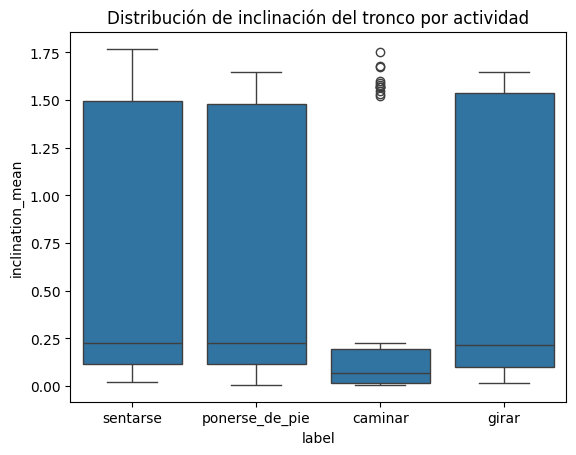

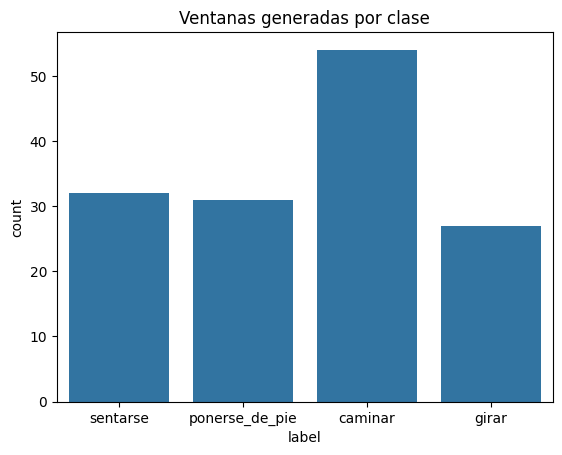

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribución de inclinación promedio por clase
sns.boxplot(x="label", y="inclination_mean", data=features_df)
plt.title("Distribución de inclinación del tronco por actividad")
plt.show()

# Conteo de ventanas por clase
sns.countplot(x="label", data=features_df)
plt.title("Ventanas generadas por clase")
plt.show()


## Conclusiones del preprocesamiento

- Se cargaron los datos desde Supabase y se procesaron correctamente.
- Los filtros de visibilidad eliminaron videos con baja calidad.
- Las coordenadas se normalizaron con referencia pélvica y escala de hombros.
- Las features agregadas (ángulos, velocidades, inclinación) se calcularon por ventana temporal.
- Se exportó un dataset balanceado por clases (`features.csv`) para el entrenamiento.
